# Preprocessing

In [53]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [54]:
# load in data with relative path
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

In [55]:
# drop columns
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

In [56]:
# scale diameters 
scaler = StandardScaler()
tree_df['tree_dbh'] = scaler.fit_transform(tree_df[['tree_dbh']])

# Ordinal Encode
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [57]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [58]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [59]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [60]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [61]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

# Logistic Regression Model

Motivation: The main reason I want to use logistic regression model with multiple classes is to set a reference for all other more complicated models to better evaluate their performances as logistic regression is the simplest one.

Metrics:
Accuracy

Hyperparameters tuning:
penalty: l1, l2, elasticnet (solver = saga)

class_weight: balanced or default

multi_class: multinomial (solver = lbfgs), ovr (solver = liblinear)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [63]:
penalty = ['l1', 'l2', 'elasticnet']
class_weight = ['balanced','']
multi_class = ['multinomial', 'ovr']
l1_ratio = [0.2, 0.4, 0.6, 0.8]

In [64]:
def logReg(x_train, y_train, x_val, y_val, penalty, weight, multi, l1_ratio):
    score = []
    auc = []
    hyper = []
    tracker = 0

    # when multi_class == 'ovr', the solver must be liblinear.
    # liblinear only support l1 and l2 penalty, and l1 doesn't work on my laptop
    model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class=multi[1], solver='liblinear')
    model.fit(x_train, y_train)
    score.append(model.score(x_val, y_val))
    hyper.append(['l2','balanced','ovr'])
    auc.append(roc_auc_score(y_val, model.predict_proba(x_val), average='weighted', multi_class='ovr'))

    model = LogisticRegression(penalty='l2', class_weight='', multi_class=multi[1], solver='liblinear')
    model.fit(x_train, y_train)
    score.append(model.score(x_val, y_val))
    hyper.append(['l2','','ovr'])
    auc.append(roc_auc_score(y_val, model.predict_proba(x_val), average='weighted', multi_class='ovr'))

    for i in penalty:
        for j in weight:
            tracker = 0
            if i != 'elasticnet':
                model = LogisticRegression(penalty=i, class_weight=j, multi_class=multi[0], solver='saga')
            else:
                while tracker != len(l1_ratio):
                    model = LogisticRegression(penalty=i, class_weight=j, multi_class=multi[0], solver='saga',l1_ratio=l1_ratio[tracker])
                    model.fit(x_train, y_train)
                    score.append(model.score(x_val, y_val))
                    hyper.append([i, j, multi[0], l1_ratio[tracker]])
                    auc.append(roc_auc_score(y_val, model.predict_proba(x_val), average='macro', multi_class='ovr'))
                    tracker += 1

                continue
            model.fit(x_train, y_train)
            score.append(model.score(x_val, y_val))
            hyper.append([i, j, multi[0]])
            auc.append(roc_auc_score(y_val, model.predict_proba(x_val), average='weighted', multi_class='ovr'))

    return hyper, score, auc


In [65]:
## Original data (best model)

# Tuning hyperparameter
hyper, val_score, auc = logReg(x_train, y_train, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)

print("Best auc: ", max(auc), "using hyperparameters ", hyper[np.argmax(auc)])
print("Bes accuracy: ", max(val_score), "using hyperparameters ", hyper[np.argmax(val_score)])


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/o

Best auc:  0.6254231337401052 using hyperparameters  ['elasticnet', '', 'multinomial', 0.8]
Bes accuracy:  0.8110265649557251 using hyperparameters  ['l2', '', 'ovr']


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


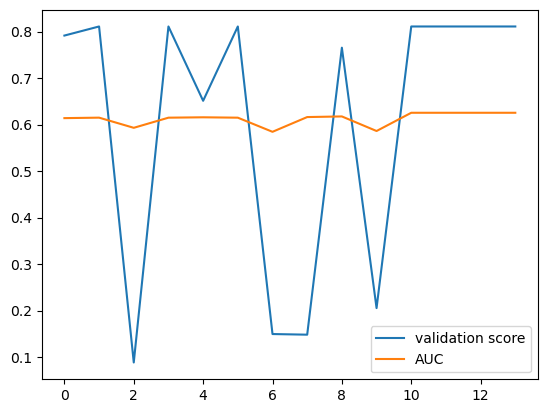

In [66]:
plt.plot(val_score, label = "validation score")
plt.plot(auc, label = "AUC")
plt.legend()

plt.show()


In [67]:
# Score on test set
model = LogisticRegression(penalty='l2', class_weight='', multi_class='ovr', solver='liblinear')
model.fit(x_train, y_train)
test_score = model.score(x_test, y_test)

print("Test accuracy: ", test_score)

Test accuracy:  0.8108085315178558


In [68]:
## Oversampling on train data

# Tuning hyperparameter
hyper, val_score, auc = logReg(x_ros, y_ros, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)

print("Best auc: ", max(auc), "using hyperparameters ", hyper[np.argmax(auc)])
print("Bes accuracy: ", max(val_score), "using hyperparameters ", hyper[np.argmax(val_score)])



/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/o

Best auc:  0.6073336397717372 using hyperparameters  ['elasticnet', '', 'multinomial', 0.2]
Bes accuracy:  0.5042645762257063 using hyperparameters  ['l2', 'balanced', 'ovr']


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


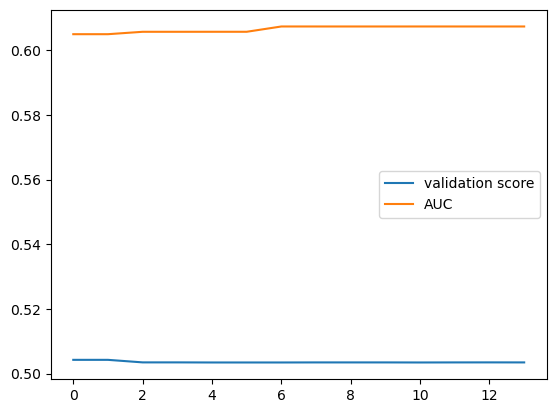

In [69]:
plt.plot(val_score, label = "validation score")
plt.plot(auc, label = "AUC")
plt.legend()

plt.show()

In [70]:
# Score on test set
model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='ovr', solver='liblinear')
model.fit(x_ros, y_ros)
test_score = model.score(x_test, y_test)

print("Test accuracy: ", test_score)

Test accuracy:  0.5047763619915053


In [71]:
## Undersampling on train data

# Tuning hyperparameter
hyper, val_score, auc = logReg(x_rus, y_rus, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)

print("Best auc: ", max(auc), "using hyperparameters ", hyper[np.argmax(auc)])
print("Bes accuracy: ", max(val_score), "using hyperparameters ", hyper[np.argmax(val_score)])


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/o

Best auc:  0.6051103428856313 using hyperparameters  ['elasticnet', '', 'multinomial', 0.2]
Bes accuracy:  0.4995208341319431 using hyperparameters  ['l2', 'balanced', 'ovr']


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


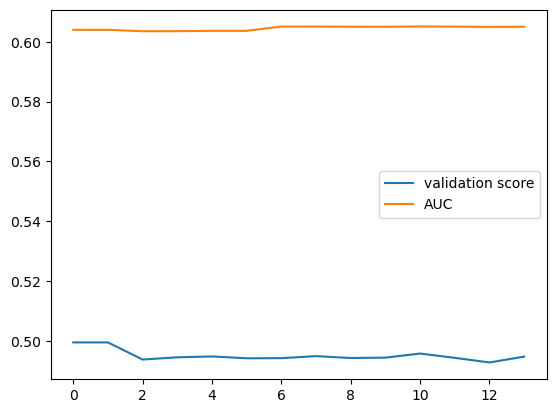

In [72]:
plt.plot(val_score, label = "validation score")
plt.plot(auc, label = "AUC")
plt.legend()

plt.show()

In [73]:
# Score on test set using hyperparameters with best accuracy
model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='ovr', solver='liblinear')
model.fit(x_rus, y_rus)
test_score = model.score(x_test, y_test)

print("Test accuracy: ", test_score)

Test accuracy:  0.4997163316313231


In [74]:
## SMOTE on train data

# Tuning hyperparameter
hyper, val_score, auc = logReg(x_smote, y_smote, x_val, y_val, penalty, class_weight, multi_class, l1_ratio)

print("Best auc: ", max(auc), "using hyperparameters ", hyper[np.argmax(auc)])
print("Bes accuracy: ", max(val_score), "using hyperparameters ", hyper[np.argmax(val_score)])


/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yuanchenwei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


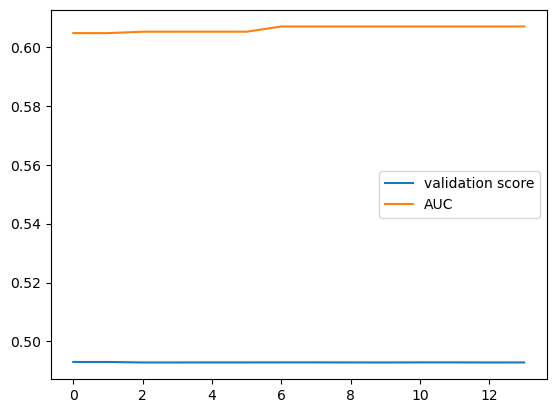

In [ ]:
plt.plot(val_score, label = "validation score")
plt.plot(auc, label = "AUC")
plt.legend()

plt.show()

In [ ]:
# Score on test set using hyperparameters with best accuracy
model = LogisticRegression(penalty='l2', class_weight='balanced', multi_class='ovr', solver='liblinear')
model.fit(x_smote, y_smote)
test_score = model.score(x_test, y_test)

print("Test accuracy: ", test_score)

Test accuracy:  0.49366729533710535
